In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%run ../src/core.py
%run ../src/lpf.py
%run ../extcore.py

In [3]:
from scipy.signal import medfilt as MF
from scipy.stats import scoreatpercentile as sap
from scipy.optimize import fmin, fmin_powell

In [4]:
N = lambda a: a/median(a)

In [603]:
%run -i lpf_white.py

In [389]:
#lpf = LPFC(noise='red', constant_k=True, use_ldtk=True)

In [604]:
lpf = LPFC(noise='white', constant_k=True, use_ldtk=False)

In [605]:
de = DiffEvol(lpf.lnposterior, lpf.ps.bounds, 100, maximize=True, F=0.45, C=0.25)
fc = pd.read_hdf(join('..',result_file), 'vkrn_ldtk/fc')
sample = permutation(fc)[:de.n_pop]
de._population[:, 0:5] = sample[:,0:5]
de._population[:,lpf.ibla] = normal(1, 1e-2, size=(de.n_pop, lpf.nlc))

-6734.77478979


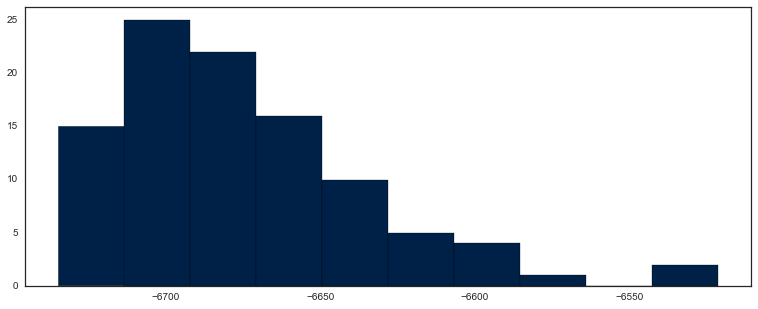

In [637]:
de.optimize(500)
hist(de._fitness)
print de.minimum_value

In [640]:
pv = fmin_powell(lambda pv: -lpf.lnposterior(pv), de.minimum_location)

Optimization terminated successfully.
         Current function value: -6751.146983
         Iterations: 3
         Function evaluations: 1037


In [377]:
de._population[0,:] = pv

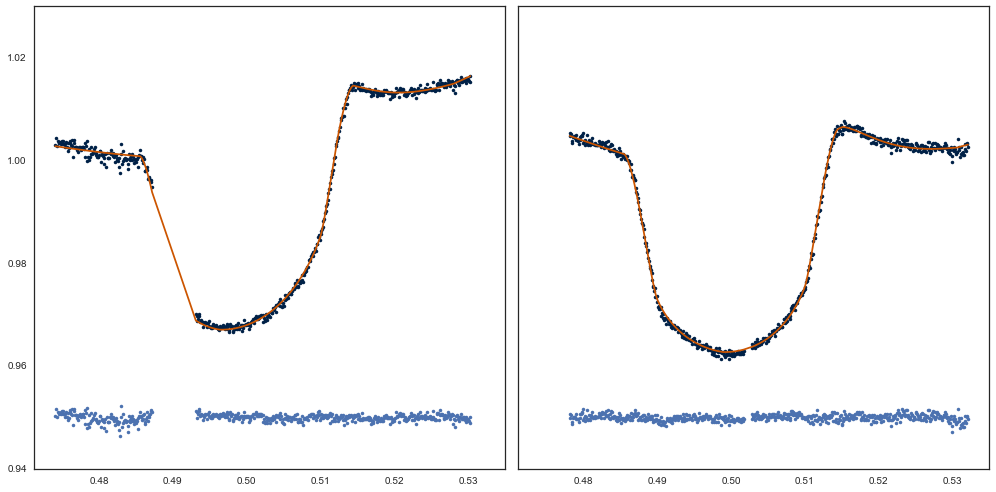

In [641]:
#pv = de.minimum_location.copy()
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(1,2,figsize=(14,7), sharey=True, sharex=True)
for i in range(2):
    phase = fold(lpf.times[i], pv[1], pv[0], 0.5)
    res = fos[i]-fms[i]
    axs.flat[i].plot(phase, fos[i], '.')
    axs.flat[i].plot(phase, fms[i])
    axs.flat[i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()

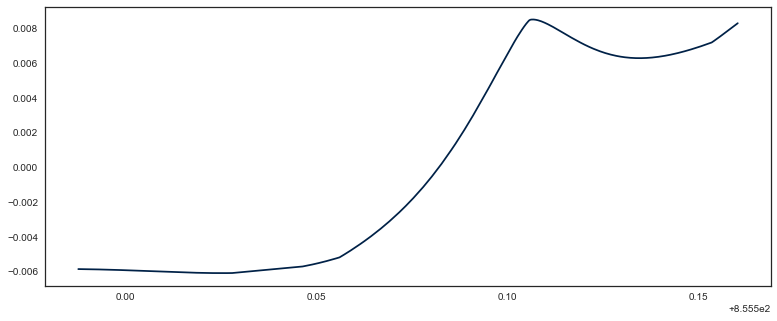

In [626]:
plot(lpf.times[0], lpf.rafun(lpf.rotang[0].values, de.minimum_location))

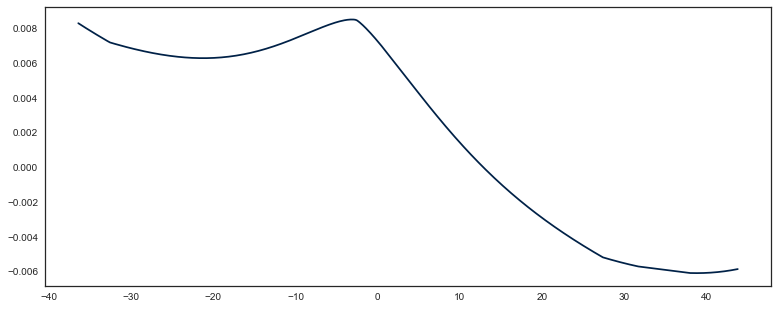

In [627]:
def rafun(rotang, pv):
    l,a,c,p,w = pv[lpf.iblr]
    return l*rotang + a*exp(-abs(((rotang-c)+30)%60-30)**p/w)

plot(lpf.rotang[0], rafun(lpf.rotang[0].values, de.minimum_location));

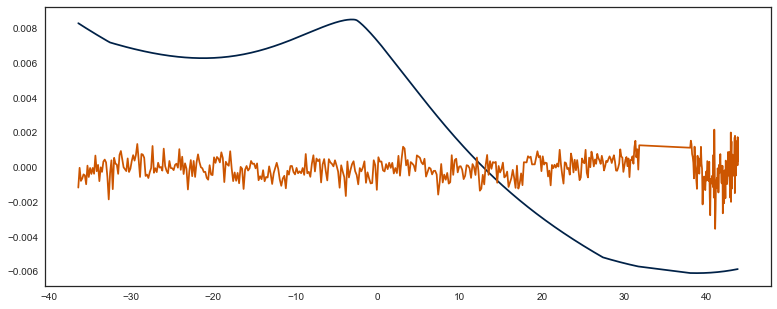

In [630]:
plot(lpf.rotang[0], lpf.rafun(lpf.rotang[0].values, de.minimum_location))
plot(lpf.rotang[0], res[0])

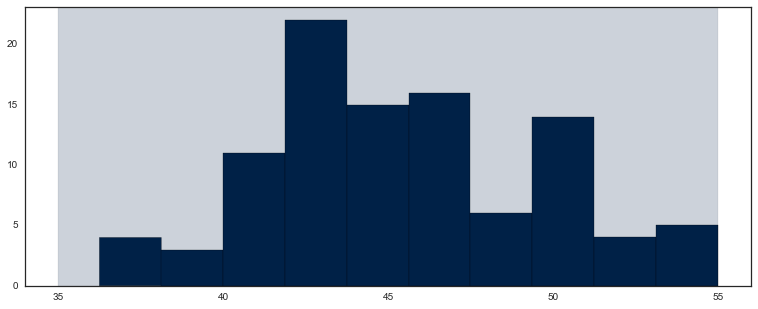

In [647]:
i = lpf.iblr[4]
hist(de.population[:,i])
axvspan(*lpf.ps.priors[i].limits(), alpha=0.2)

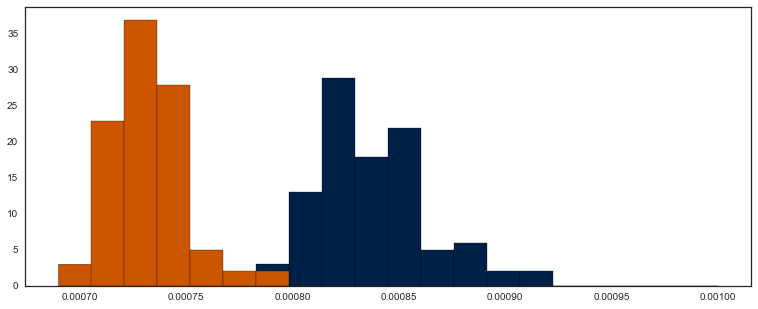

In [484]:
[hist(de.population[:,i], bins=20, range=(6.9e-4,1e-3)) for i in lpf.iwn];

In [652]:
res = [fo-fm for fo,fm in zip(fos,fms)]

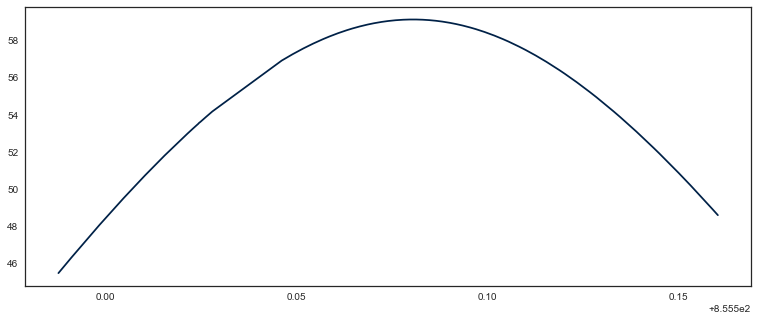

In [452]:
plot(lpf.times[0], lpf.elevat[0])

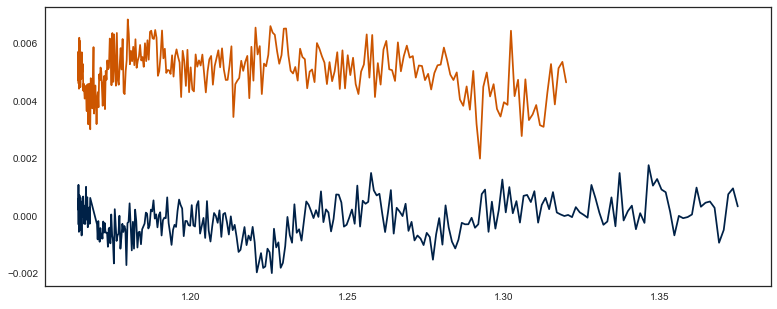

In [462]:
j = 1
i = argmax(lpf.elevat[j])
plot(lpf.airmass[j][:i], res[j][:i])
plot(lpf.airmass[j][i:], res[j][i:]+0.005)

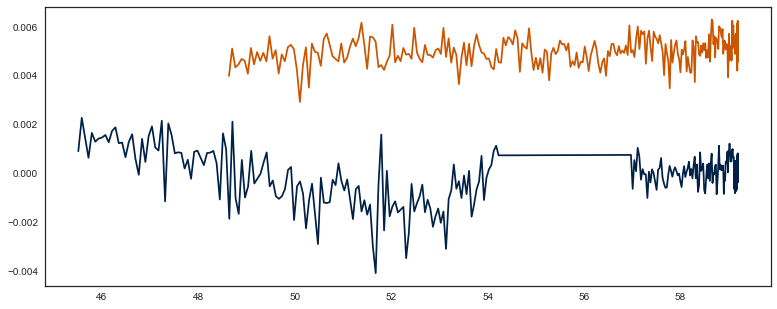

In [458]:
j = 0
i = argmax(lpf.elevat[j])
plot(lpf.elevat[j][:i], res[j][:i])
plot(lpf.elevat[j][i:], res[j][i:]+0.005)

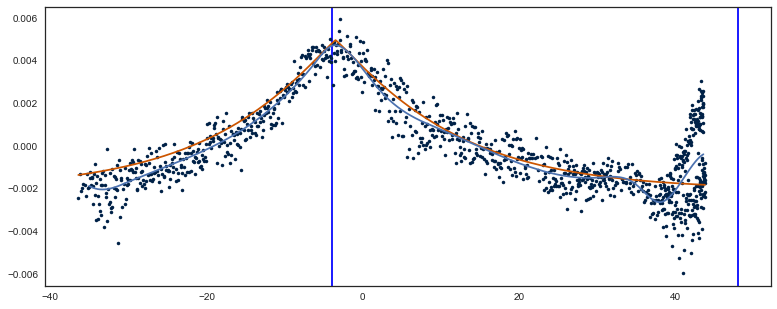

In [348]:
ra = concatenate(lpf.rotang)
rr = concatenate(res)

sids = argsort(ra)
s = LSQUnivariateSpline(ra[sids], rr[sids], t=[-35,-30,-6,-4,-2,2,10,30,35,38])
#plot(lpf.rotang[0],res[0], '-')
axvline(-4)
axvline(48)
plot(ra,rr, '.')
plot(ra[sids], 0.007*exp(-abs(-3.5-ra[sids])**1.1/20)-0.002)
#plot(lpf.rotang[1],res[1], '-')
plot(lpf.rotang[1], s(lpf.rotang[1]))

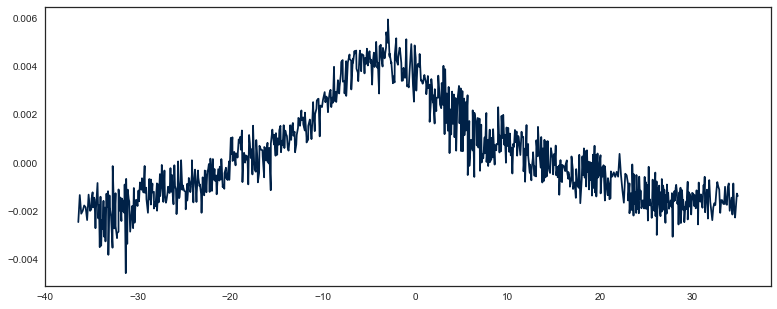

In [350]:
raa, rrr = ra[sids], rr[sids]
rms = raa < 35

plot(raa[rms],rrr[rms])

In [355]:
def modelfun(pv):
    return pv[0]*exp(-abs(pv[1]-raa)**pv[2]/pv[3])+pv[4]
    
def minfun(pv):
    return sum((rrr - modelfun(pv))**2)

In [357]:
pvv = fmin(minfun, [0.007, -3.5, 1.1, 20, -0.002])

Optimization terminated successfully.
         Current function value: 0.001364
         Iterations: 241
         Function evaluations: 403


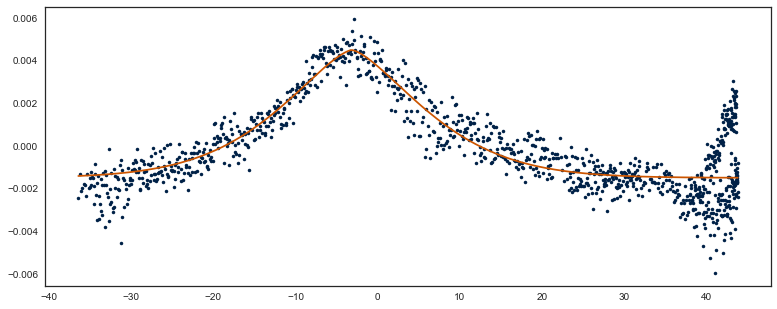

In [359]:
plot(raa, rrr, '.')
plot(raa, modelfun(pvv))

In [361]:
pvv

array([  5.99173038e-03,  -3.16410984e+00,   1.45814075e+00,
         3.91975768e+01,  -1.45711270e-03])

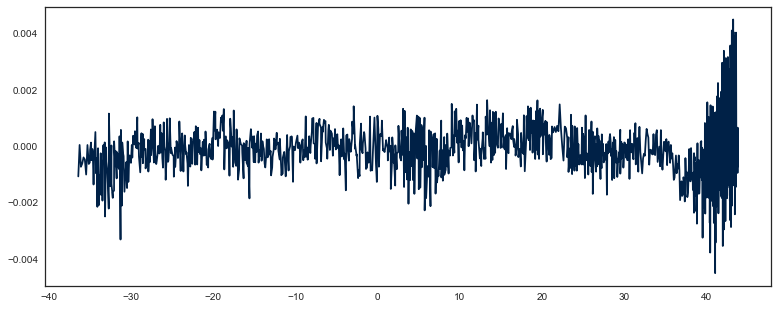

In [360]:
plot(raa, rrr-modelfun(pvv))

In [306]:
tt = res[1] - s(lpf.rotang[1])

In [247]:
gp = GPT(lpf.rotang[1], res[1])
gp.priors[1] = UP( 5e-5, 5e5,    'its')
gp.ps = PriorSet(gp.priors)
gp.fit([-3,0.1,-3])

array([-2.98600621,  0.06701232, -3.25199968])

In [249]:
gp = GPT(lpf.rotang[0], res[0])
gp.priors[1] = UP( 5e-5, 5e5,    'its')
gp.ps = PriorSet(gp.priors)
gp.fit([-3,0.1,-3])

array([-2.69195574,  0.04870855, -3.21208904])

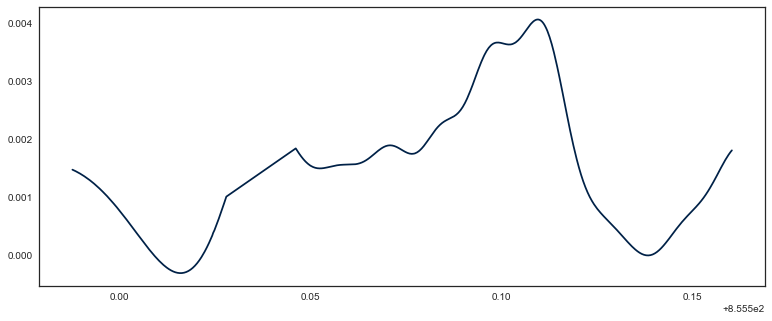

In [251]:
plot(lpf.times[0], gp.predict())

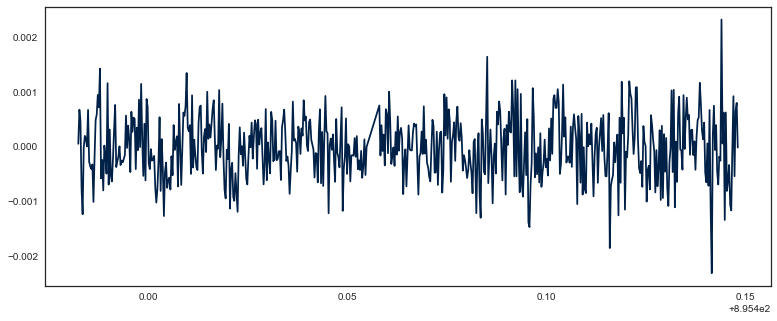

In [222]:
plot(lpf.times[1], tt)

In [427]:
sampler = EnsembleSampler(de.n_pop, de.n_par, lpf.lnposterior)

In [428]:
sampler.run_mcmc(de.population, 50);

In [440]:
sampler.run_mcmc(sampler.chain[:,-1,:], 225);

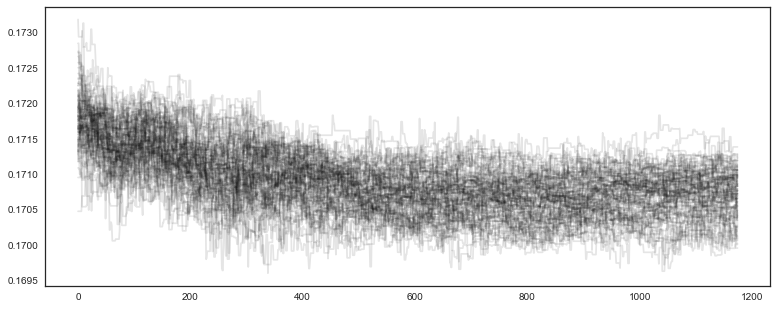

In [443]:
plot(sqrt(sampler.chain[:,:,4].T), 'k', alpha=0.1);

In [444]:
fc = pd.read_hdf(join('..',result_file), 'ckrn_ldtk/fc')

In [445]:
dff = pd.DataFrame(sampler.chain[:,600::20,:].reshape([-1,lpf.ps.ndim]), columns=lpf.ps.names)

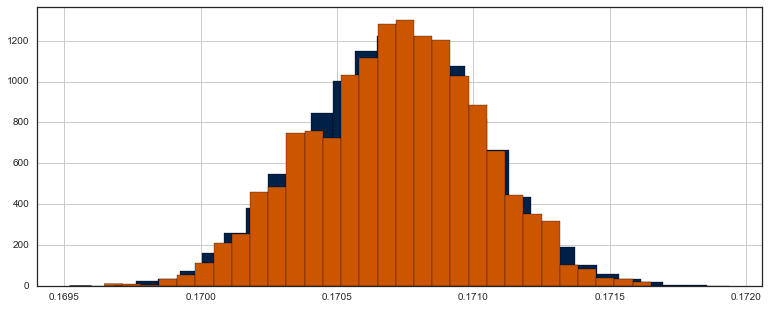

In [446]:
sqrt(fc.k2).hist(normed=True, bins=30)
sqrt(dff.k2).hist(normed=True, bins=30)